<a href="https://colab.research.google.com/github/nibaskumar93n-debug/Morphoinformatics/blob/main/ashik_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
file_path = "/content/Book11.xlsx"   # <-- change filename only
df = pd.read_excel(file_path)

df.head()


,Sam. No.,Latitude,Longitude,Ni,V,Co,Cd,Fe,Mn,As,Zn,Pb,Cr,Cu
0,ASA-1,"22°31'22""N","89°09'14""E",32.1,63.8,51.4,0.340000,27946.15,596.548125,7.902725,84.850000,30.285283,121.113281,51.7
1,ASA-2,"22°30'38""N","89°09'20""E",38.1,68.8,58.4,3.713396,32341.50,638.338235,7.202664,66.887868,37.443623,149.509688,59.1
2,ASA-3,"22°30'18""N","89°09'29""E",38.9,73.8,61.1,2.000000,33942.60,492.063158,7.325786,77.447368,45.091421,179.843906,58.3
3,ASA-4,"22°29'50""N","89°09'20""E",36.5,63.8,55.6,0.120000,28941.75,619.801875,7.873208,72.493750,31.396226,125.585156,57.3
4,ASA-5,"22°29'23""N","89°09'35""E",36.5,68.8,57.0,3.737547,34847.50,644.476103,7.647799,81.590074,37.826818,150.987891,55.5


In [6]:
BW_adult = 70       # Body weight (kg)
InhR_adult = 20     # mg/day soil ingestion
ED_adult = 30       # exposure duration (years)
AT_nc_adult = ED_adult * 365     # non-cancer average time
AT_cancer = 70 * 365             # cancer risk average time
EF = 350                         # Exposure frequency (days/year)
BW_child = 15
InhR_child = 100
ED_child = 6
AT_nc_child = ED_child * 365
RfD = {
    "Ni": 0.02,
    "V": 0.007,
    "Co": 0.0003,
    "Cd": 0.001,
    "As": 0.0003,
    "Pb": 0.0035,
    "Cr": 0.003,
    "Cu": 0.04,
    "Zn": 0.3,
    "Mn": 0.14,
    "Fe": 0.7
}
SF = {
    "As": 1.5,        # most important carcinogenic metal
    "Cd": 6.1,
    "Cr": 0.5
}


In [7]:
def monte_carlo_risk(concentration, RfD, BW, InhR, AT):
    runs = 10000
    # Assume lognormal distribution
    mu = np.log(concentration.mean())
    sigma = concentration.std() / concentration.mean()

    simulated_C = np.random.lognormal(mean=mu, sigma=sigma, size=runs)

    ADD = simulated_C * InhR * EF * ED_adult / (BW * AT)
    HQ = ADD / RfD
    return ADD, HQ


In [9]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())


['Sam. No.', 'Latitude', 'Longitude', 'Ni', 'V', 'Co', 'Cd', 'Fe', 'Mn', 'As', 'Zn', 'Pb', 'Cr', 'Cu']


In [10]:
def monte_carlo_risk(concentration, RfD, BW, InhR, ED, EF, AT):
    runs = 10000

    # lognormal parameters
    mu = np.log(concentration.mean())
    sigma = concentration.std() / concentration.mean()

    simulated_C = np.random.lognormal(mean=mu, sigma=sigma, size=runs)

    ADD = simulated_C * InhR * EF * ED / (BW * AT)
    HQ = ADD / RfD

    return ADD, HQ



In [11]:
results = {}

for metal in RfD.keys():
    conc = df[metal]

    ADD_adult, HQ_adult = monte_carlo_risk(
        concentration = conc,
        RfD = RfD[metal],
        BW = BW_adult,
        InhR = InhR_adult,
        ED = ED_adult,
        EF = EF,
        AT = AT_nc_adult
    )

    results[metal] = {
        "ADD_adult": ADD_adult,
        "HQ_adult": HQ_adult
    }

In [12]:
for metal in results.keys():
    HQ = results[metal]["HQ_adult"]
    print(f"{metal} — HQ (mean): {HQ.mean():.4f},  HQ (95th percentile): {np.percentile(HQ,95):.4f}")


Ni — HQ (mean): 581.5565,  HQ (95th percentile): 723.6051
V — HQ (mean): 3090.2239,  HQ (95th percentile): 3819.6937
Co — HQ (mean): 54213.5375,  HQ (95th percentile): 63888.8160
Cd — HQ (mean): 806.5504,  HQ (95th percentile): 1623.3528
As — HQ (mean): 7476.6821,  HQ (95th percentile): 9826.5021
Pb — HQ (mean): 2869.0259,  HQ (95th percentile): 3525.0340
Cr — HQ (mean): 13313.5230,  HQ (95th percentile): 16260.5912
Cu — HQ (mean): 408.8415,  HQ (95th percentile): 479.0250
Zn — HQ (mean): 69.7594,  HQ (95th percentile): 93.2856
Mn — HQ (mean): 1276.3825,  HQ (95th percentile): 1768.9024
Fe — HQ (mean): 15392.2805,  HQ (95th percentile): 21699.5725


In [13]:
HI_adult = np.sum([results[m]["HQ_adult"] for m in results.keys()], axis=0)

print("Hazard Index (HI):")
print(f"Mean HI: {HI_adult.mean():.4f}")
print(f"95th percentile HI: {np.percentile(HI_adult,95):.4f}")


Hazard Index (HI):
Mean HI: 99498.3634
95th percentile HI: 111792.7305


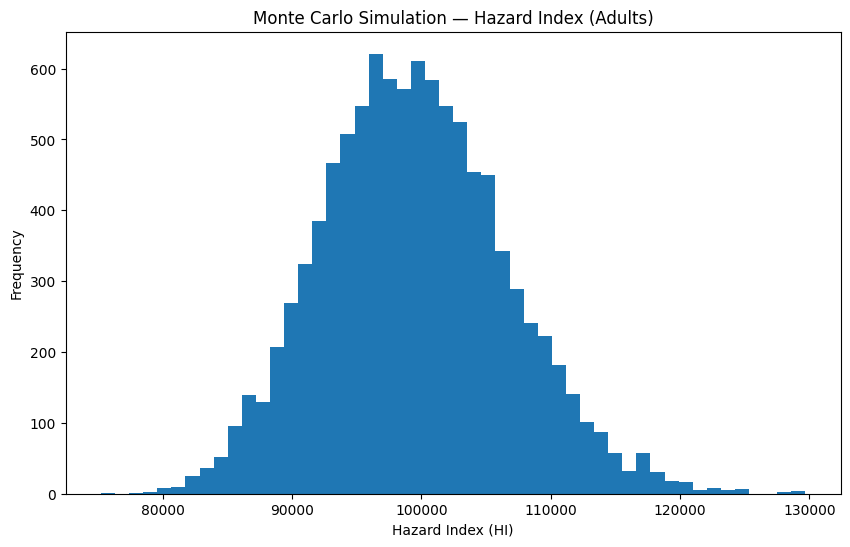

In [14]:
plt.figure(figsize=(10,6))
plt.hist(HI_adult, bins=50)
plt.xlabel("Hazard Index (HI)")
plt.ylabel("Frequency")
plt.title("Monte Carlo Simulation — Hazard Index (Adults)")
plt.show()


In [16]:
# Cancer slope factors (USEPA)
SF = {
    "As": 1.5,
    "Cd": 6.1,
    "Cr": 0.5
}

CR = {}   # dictionary for storing carcinogenic risk values

for metal in SF.keys():
    conc = df[metal]

    # Monte Carlo ADD for cancer (AT = 70 yrs)
    ADD_cancer, _ = monte_carlo_risk(
        concentration = conc,
        RfD = RfD[metal],
        BW = BW_adult,
        InhR = InhR_adult,
        ED = ED_adult,
        EF = EF,
        AT = AT_cancer      # different for cancer
    )

    CR[metal] = ADD_cancer * SF[metal]

# Total cancer risk
Total_CR = np.sum([CR[m] for m in CR.keys()], axis=0)


In [17]:
print("Carcinogenic Risk:")
for metal in CR.keys():
    print(f"{metal}: Mean CR = {CR[metal].mean():.2e}, 95th percentile = {np.percentile(CR[metal],95):.2e}")

print(f"Total Cancer Risk (Mean): {Total_CR.mean():.2e}")
print(f"Total Cancer Risk (95th percentile): {np.percentile(Total_CR,95):.2e}")


Carcinogenic Risk:
As: Mean CR = 1.45e+00, 95th percentile = 1.91e+00
Cd: Mean CR = 2.09e+00, 95th percentile = 4.17e+00
Cr: Mean CR = 8.54e+00, 95th percentile = 1.04e+01
Total Cancer Risk (Mean): 1.21e+01
Total Cancer Risk (95th percentile): 1.48e+01


In [18]:
output = pd.DataFrame({
    "Metal": list(results.keys()),
    "HQ_mean": [results[m]["HQ_adult"].mean() for m in results.keys()],
    "HQ_95th": [np.percentile(results[m]["HQ_adult"],95) for m in results.keys()]
})

output.loc[len(output)] = ["HI_total", HI_adult.mean(), np.percentile(HI_adult,95)]

output.to_excel("/content/Monte_Carlo_Risk_Output.xlsx", index=False)
print("Saved to: Monte_Carlo_Risk_Output.xlsx")


Saved to: Monte_Carlo_Risk_Output.xlsx
